#### <b>실습 전에 준비할 내용</b>

* 본 실습에서는 GPU가 필요하다.
  * Google Colab에서는 <b>Tesla T4 GPU</b>를 무료로 제공한다.
* <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - 하드웨어 가속기로 <b>[GPU]</b>를 선택한다.
* 본 실습은 아래의 Diffuser 라이브러리의 설명을 참고하여 제작되었다.
  * https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

#### <b>GPU Availability Check</b>

* Check type of <b>GPU</b> and <b>VRAM</b> available.
* GPU의 종류(type)와 VRAM을 사용할 수 있는지 확인할 수 있다.

<pre>
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader
</pre>

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


#### <b>필요한 라이브러리 설치하기</b>

* <b>Diffuers</b>: HuggingFace에서 제공하는 라이브러리로, <b>Diffusion Model을 손쉽게 사용</b>해 볼 수 있도록 도와준다.
* <b>트리톤(Triton)</b>: GPU 프로그래밍 언어 중 하나다.
  * 트리톤 서버는 기계 학습 모델 추론(inference) 서버 중 하나다.
  * 학습된 모델 파일을 올리기만 하면, 별도의 코드 없이 해당 모델에 대한 추론 API를 만들 수 있다.
* <b>xFormers</b>: Toolbox to Accelerate Research on Transformers.
  * 트랜스포머(transformer)를 효율적이게 동작하도록 만들기 위한 라이브러리 중 하나다.

In [2]:
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.2

#### <b>사전 학습된 모델 사용해보기(Using Pre-trained Models)</b>

* 대표적인 Stable Diffusion 모델을 불러와 사용할 수 있다.
* 기본적으로 <b>Diffuser 라이브러리</b>는 단일 모델이 아닌 <b>파이프라인(pipeline)</b> 형태로 Diffusion Model을 사용할 수 있도록 한다.

<b>Safe-tensors</b>: 허깅 페이스(HuggingFace)에서 주도적으로 개발하고 있는 새로운 모델 가중치 표현 방식이다.
  * 기존 .ckpt 파일과 비교했을 때, 프로그래밍 언어 및 프레임워크에 대한 호환성이 높다.
  * 기존 .ckpt 파일과 비교했을 때, 하나의 파일로 구성된다는 점에서 파일 크기가 작고, 관리하기 쉽다.
  * 기존 .ckpt 파일과 비교했을 때, 상대적으로 보안성이 뛰어나다.

In [3]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:105: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('//172.28.0.1'), PosixPath('8013')}
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url=http

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [4]:
print(pipe)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.15.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



#### <b>Stable Diffusion을 사용해 이미지 생성하기</b>

* 내가 원하는 텍스트 프롬프트를 넣어 이미지를 생성할 수 있다.

In [5]:
prompt = "a photo of nothing"
image = pipe(prompt).images[0]

image.save("result.png")

  0%|          | 0/50 [00:00<?, ?it/s]

#### <b>NSFW (Not Safe For Work)</b>

* Stable Diffusion은 기본적으로 많은 양의 학습 데이터를 이용하고 있다.
  * 그렇기에 자연스럽게 <b>NSFW (Not safe for work)</b> 이미지를 생성할 수 있는 능력을 가지고 있다.
  * 하지만, 기본적으로 이러한 이미지를 생성하는 것은 권장되지 않는다.
* Stable Diffusion Pipeline에서는 NSFW 이미지를 자동을 탐지하는 기술을 가지고 있다.
* 다시 말해, 의도하지 않게 자신의 생성 AI 서비스에서 원치 않는 이미지를 내보낼 수 있다는 점에서 유의할 필요가 있다.
  * Diffuser 라이브러리의 <b>파이프라인(pipeline)</b>에서는 검출 시스템을 제공한다.
  * 경우에 따라 <b>NSFW 탐지 시스템</b>에 의하여 다음과 같은 메시지가 나올 수 있다.

<pre>
* Potential NSFW content was detected in one or more images.
* A black image will be returned instead. Try again with a different prompt and/or seed.
</pre>

* NSFW에 대한 <b>safety check 기능을 끄기 위해서</b>는 다음의 코드를 실행할 수 있다.

<pre>
pipe.safety_checker = lambda images, clip_input: (images, False)
</pre>

In [6]:
pipe.safety_checker = lambda images, clip_input: (images, False)

#### <b>Install Requirements</b>

* <b>train_dreambooth.py</b>: 실질적으로 <b>Dream Booth</b> 논문의 기법을 이용해 Diffusion Model을 Fine-tuning할 수 있도록 해주는 코드

In [7]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py

#### <b>Stable Diffusion Models 설명</b>

* <b>Stable Diffusion</b>
  * A latent text-to-image diffusion model capable of generating photo-realistic images given any text input.
  * 사용할 모델 이름: <b>runwayml/stable-diffusion-v1-5</b>
* <b>(1) v1-5-pruned-emaonly.ckpt</b> - 4.27GB, ema-only weight. uses less VRAM - suitable for inference.
* <b>(2) v1-5-pruned.ckpt</b> - 7.7GB, ema+non-ema weights. uses more VRAM - suitable for fine-tuning.
* 본 실습에서 사용할 구체적인 모델에 대하여 확인하기 위해서는 <b>모델 카드(model card)</b> 내용을 확인할 필요가 있다.
  * <b>모델 카드(model card)</b>: https://huggingface.co/runwayml/stable-diffusion-v1-5
  * 특정한 모델의 경우 <b>허깅 페이스</b> 로그인 및 약관 동의가 필요할 수 있다.

<pre>
@InProceedings{Rombach_2022_CVPR,
    author    = {Rombach, Robin and Blattmann, Andreas and Lorenz, Dominik and Esser, Patrick and Ommer, Bj\"orn},
    title     = {High-Resolution Image Synthesis With Latent Diffusion Models},
    booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
    month     = {June},
    year      = {2022},
    pages     = {10684-10695}
}
</pre>

#### <b>모델 Fine-Tuning을 위한 환경 설정(Configuration)</b>

* 현재 실행 중인 Google 계정의 <b>Google Drive에 마운트(mount)</b>할 것인지 설정한다.
* If model weights should be saved directly in google drive (takes around 4-5 GB).
  * 희망한다면 <b>save_to_gdrive</b>의 값으로 True를 설정한다.
  * Google Drive의 여유 공간이 5GB 이상 있어야 한다.

In [8]:
save_to_gdrive = True # Google Drive에 저장하고자 하는 경우 True로 설정

if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


* <b>MODEL_NAME</b>
  * 초기 모델의 이름(name) 혹은 경로(path)를 의미한다
  * Name/Path of the initial model.
* <b>OUTPUT_DIR</b>: Enter the directory name to save model at.
  * 모델을 저장할 폴더(directory) 경로를 기입한다.

In [9]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
OUTPUT_DIR = "stable_diffusion_weights/zwx"

if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print("모델 출력(저장) 경로:", OUTPUT_DIR)

모델 출력(저장) 경로: /content/drive/MyDrive/stable_diffusion_weights/zwx


* 실질적으로 <b>학습될 모델 가중치의 저장 경로</b>를 확인한다.
  * Google Drive를 사용하는 경우(Google Drive에 폴더를 생성하기)
  * 단순히 Colab 내부에서 사용하는 경우

In [10]:
!mkdir -p $OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

[*] Weights will be saved at /content/drive/MyDrive/stable_diffusion_weights/zwx


#### <b>학습할 이미지 설정 및 업로드</b>

* 동시에 <b>여러 개의 콘셉트(concepts)</b>를 대상으로 학습을 진행할 수 있다.
* 하나의 콘셉트마다 instance와 class 정보를 기입한다.
  * <b>Concept example (1)</b>
    * instance: 내가 기르는 한 마리의 강아지
    * class: 다양한 <b>강아지</b> 사진
  * <b>Concept example (2)</b>
    * instance: 내 사진
    * class: 일반적인 다른 <b>사람</b>에 대한 사진
* 사용 예시는 다음과 같다.

<pre>
concepts_list = [
    {
        "instance_prompt":      "photo of zwx dog",
        "class_prompt":         "photo of a dog",
        "instance_data_dir":    "/content/data/zwx",
        "class_data_dir":       "/content/data/dog"
    }
]
</pre>

* 만약 <b>여러 개의 콘셉트(concept)</b>에 대하여 학습하고자 한다면, 다음과 같은 방식으로 학습할 수 있다.
  * 단 학습할 콘셉트의 수가 많다면, <b>학습 반복(step) 횟수</b>를 조절해 볼 필요가 있다.
  * You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

<pre>
concepts_list = [
    {
        "instance_prompt":      "photo of zwx dog",
        "class_prompt":         "photo of a dog",
        "instance_data_dir":    "/content/data/zwx",
        "class_data_dir":       "/content/data/dog"
    },
    {
        "instance_prompt":      "photo of ukj person",
        "class_prompt":         "photo of a person",
        "instance_data_dir":    "/content/data/ukj",
        "class_data_dir":       "/content/data/person"
    }
]
</pre>

* 이미지를 업로드하는 방식은 여러 가지가 있다.

1. 왼쪽에서 Google Colab의 <b>[파일]</b> 탭을 열어서 일일이 내가 원하는 사진 넣기
  * 왼쪽에서 <b>업로드 버튼</b>을 눌러 직접 사진을 선택하여 업로드할 수 있다.
  * You can use the file manager on the left panel to upload (drag and drop) to each `instance_data_dir` (it uploads faster).
2. <b>Google Colab 파일 업로드 라이브러리</b>를 이용해 내가 원하는 사진 업로드하기
  * 본 세션의 /content/ 경로에 업로드됩니다.
3. 만약 구글 드라이브에 마운트를 했다면, 직접 여기에서 불러오도록 할 수 있다.
  * 본 실습에서는 <b>Google Drive</b>의 <b>My Drive/images/cats</b> 경로에 모든 이미지를 넣은 뒤에 이를 학습 데이터로 사용한다.
* 만약 <b>Stable Diffusion (SD)</b>를 사용해 클래스 이미지를 생성하는 것을 원하지 않을 수 있다.
  * 이러한 경우에는 마찬가지로 <b>class_data_dir</b> 경로에 자신의 클래스(class) 이미지를 넣을 수 있다.
  * You can also upload your own class images in `class_data_dir` if u don't wanna generate with SD.
* 아래 코드를 사용하면, 직접 현재의 <b>세션(session)</b>에서 사용할 학습 이미지를 직접 업로드하여 사용할 수 있다.

In [ ]:
# 본 실습에서 사용할 학습 이미지 파일들의 경로 확인하기
!ls /content/drive/MyDrive/images/man_1

IMG_2254.jpg  IMG_2255.jpg  IMG_2256.jpg  IMG_2257.jpg	IMG_2258.jpg


In [11]:
concepts_list = [
    {
        "instance_prompt":      "photo of zwx korean man",
        "class_prompt":         "photo of a korean man",
        "instance_data_dir":    "/content/drive/MyDrive/images/jaypark",
        "class_data_dir":       "/content/drive/MyDrive/images/korean_men"
    },
    {
        "instance_prompt":      "profile photo of zwx korean man",
        "class_prompt":         "profile photo of a korean man",
        "instance_data_dir":    "/content/drive/MyDrive/images/jaypark_profiles",
        "class_data_dir":       "/content/drive/MyDrive/images/korean_profiles"
    }
]

# "class_data_dir" 폴더에서는 정규화된 이미지 정보를 가지고 있게 된다.
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

#### <b>(선택) Google Colab 파일 업로드 기능</b>

In [ ]:
import os
from google.colab import files
import shutil


# 콘셉트(concept) 리스트를 하나씩 확인하며
for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    # 파일 경로에서 여러 개의 이미지를 선택하여 업로드할 수 있다.
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)

#### <b>학습 데이터 업로드시 참고 사항</b>

<b>instance images</b>: 하나의 객체(object)에 대하여 다양하게 촬영한 이미지 집합
* 이때 인스턴스(instance)는 한 명 혹은 한 마리의 <b>객체(object)</b>를 의미한다.
* 일반적으로 한 명의 대상에 대한 <b>동영상</b>이 있다면, 해당 대상에 대하여 많은 이미지를 한꺼번에 얻을 수 있습니다.
  * 예를 들어 자신의 얼굴을 활용한 생성 이미지를 원한다면, 자신을 촬영한 이미지를 사용한다.
  * 혹은 자신의 동영상을 찍은 뒤에, 여기에서 일부 이미지 프레임(frame)을 추출한다.
  * 이후에 그것으로 instance images 집합을 구성할 수 있다.

<b>class images</b>: 자신이 선택한 instance를 포함하는 다양한 이미지 집합
* 해당 객체 말고 다른 객체들도 포함하는 <b>클래스 객체들의 집합</b>으로 이해할 수 있다.
* 잘 알려진 클래스인 경우 별도로 데이터 수집이 필요 없을 수 있다.
  * Diffusion Model에서 해당 클래스의 이미지를 생성한 뒤에 사용할 수 있기 때문이다.
  * 예를 들어 강아지, 고양이, 남성 사진 등은 이미 사전 학습된 Diffusion Model에 많이 쓰였을 것이다.


#### <b>Fine-tuning 과정에서 사용할 수 있는 기법들 알아보기</b>

<b>1. Half Precision (16 bits)</b>

* 기본적으로 PyTorch에서 딥러닝 모델을 학습할 때는 실수를 표현할 때 4 bytes (32 bits)를 사용한다.
* <b>Half-precision</b>: FP16(Half Precision)을 사용하면 2 bytes만 사용하면 된다.
  * GPU를 활용할 때 연산 속도가 빨라진다.
  * 정밀도가 떨어진다는 점에서 오차에 의해 정답과 거리가 멀어질 수 있다.

<b>2. 기울기 누적(Gradient Accumulation)</b>

* A mechanism to split the batch of samples.
* <b>참고</b>: https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa
* 더 적은 메모리를 사용하여, 배치 크기가 적은 상황에서도 <b>배치 크기가 큰 것과 유사한 효과</b>를 낼 수 있다.
* <b>backward()</b> 이후에 각 가중치 파라미터의 gradient 값이 기록된다.
  * 여기에 추가적으로 backward()를 수행할 때마다 가중치 값이 누적되는 특징이 있다.
* <b>기울기 누적 예시(Example)</b>
  * gradient_accumulation_steps = 2
  * mini-batch = 1
  * 다음과 같이 2개의 미니 배치에 대하여 bacward를 진행한 뒤에, 업데이트는 한 번만 수행한다.
  * 실제로 gradient를 이용해 업데이트를 진행하는 과정은 미니배치 2번당 1번만 수행한다.

<pre>
device = "cuda"
model.to(device)

gradient_accumulation_steps = 2

for index, batch in enumerate(training_dataloader):
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss = loss / gradient_accumulation_steps
    loss.backward()
    if (index + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
</pre>

<b>3. Gradient Checkpoint (기울기 체크포인트)</b>

* <b>GPU 메모리의 한계를 극복</b>하기 위해 사용할 수 있는 방법 중 하나다.
  * 연산 시간은 증가하지만, 메모리 사용량이 줄어든다.
* 따라서 Gradient Checkpoint 또한 마찬가지로 GPU에 한 번에 올라가지 않는 모델을 올리기 위해 사용할 수 있다.
* (예시) 아키텍처 및 데이터마다 다를 수 있다.
  * 연산 시간이 1.3배 정도 늘어나는 데에 비해 메모리 사용량이 절반으로 줄어드는 경우도 볼 수 있다.
* <b>Gradient Checkpointing 경로</b>: https://github.com/cybertronai/gradient-checkpointing

<b>어떻게 방식으로 동작하는가?</b>

* 뒤쪽의 노드에 대하여 기울기(gradient)를 계산 할 때를 생각해 보자.
  * <b>일반적인 역전파(back-propagation)</b> 과정에서는 앞쪽 노드에 대한 기울기 정보를 모두 유지한다.
* 하지만, <b>gradient check-pointing</b>을 사용하면, 모든 노드에 대한 기울기를 전부 저장하지는 않는다.
  * 앞쪽 노드 중에서 <b>중요 노드에 대한 기울기(gradient) 값을 유지</b>한다.

<b>단점은 무엇인가?</b>

* 메모리 사용량은 줄이지만, 연산량은 증가한다.
  * 많은 노드에 대하여 <b>기울기(gradient)를 다시 연산</b>해야 한다.
* Gradient checkpointing works by omitting some of the activation values from the computational graph.
* This reduces the memory used by the computational graph.
  * Reducing memory pressure overall (and allowing larger batch sizes in the process).

#### <b>Stable Diffusion Model의 Fine-tuning 파라미터 자세히 알아보기</b>

#### <b>Diffusion Model 관련</b>

* <b>pretrained_model_name_or_path</b>
  * 사용할 사전 학습된(pre-trained) 모델의 이름 혹은 경로
  * Path to pretrained model or model identifier from huggingface.co/models.
* <b>pretrained_vae_name_or_path</b>
  * 사용할 사전 학습된(pre-trained) VAE 모델의 이름 혹은 경로
  * Stable Diffusion 분야에서는 <b>Variational Auto-Encoder (VAE)</b>가 이미지 보정 목적으로도 활용
  * Path to pretrained vae or vae identifier from huggingface.co/models.
* <b>revision</b>
  * 사용할 사전 학습된(pre-trained) 모델을 개정(revision)하여 사용할지 설정
  * 예를 들어 16 bits floating points를 적용할 수 있다.
  * Revision of pretrained model identifier from huggingface.co/models.

#### <b>학습 데이터 관련(이미지 및 텍스트)</b>

* <b>instance_data_dir</b>
  * 인스턴스 학습 이미지들을 포함하고 있는 폴더(folder) 경로
  * A folder containing the training data of instance images.
* <b>class_data_dir</b>
  * 클래스 학습 이미지들을 포함하고 있는 폴더(folder) 경로
  * 이때 클래스(class)는 인스턴스가 속한 클래스와 동일해야 한다.
  * A folder containing the training data of class images.
* <b>instance_prompt</b>
  * 인스턴스를 지칭하는 식별자(identifier)를 포함하는 프롬프트(prompt)
  * The prompt with identifier specifying the instance.
* <b>class_prompt</b>
  * 제공된 인스턴스 이미지와 동일한 클래스의 이미지라는 것을 알려주기 위해 사용하는 프롬프트(prompt)
  * The prompt to specify images in the same class as provided instance images.
* <b>resolution</b>
  * <b>기본 값(default)</b>: 512
  * 입력 이미지의 해상도(resolution)으로, 기본 값으로 <b>512 X 512</b>를 가진다.
  * 학습 이미지는 기본적으로 이러한 해상도로 크기 변경(resize)이 수행된다.
  * The resolution for input images, all the images in the train/validation dataset will be resized to this resolution.

#### <b>이미지 생성 및 추론(Inference) 관련</b>

* <b>save_sample_prompt</b>
  * 저장할 이미지 결과물을 생성할 때 사용하는 <b>프롬프트(prompt)</b>
  * 자신이 생성하고자 하는 이미지에 대하여 "원하는 사항"을 적으면 된다.
  * The prompt used to generate sample outputs to save.
* <b>save_sample_negative_prompt</b>
  * 저장할 이미지 결과물을 생성할 때 사용하는 <b>반대 프롬프트(negative prompt)</b>
  * The negative prompt used to generate sample outputs to save.
* <b>n_save_sample</b>
  * <b>기본 값(default)</b>: 4
  * 저장하고자 하는 샘플의 개수(생성할 이미지 개수)
  * The number of samples to save.
* <b>save_guidance_scale</b>
  * <b>기본 값(default)</b>: 7.5
  * 조건(condition) 정보를 얼마나 높은 강도로 적용할지 설정할 수 있다.
  * CFG (Classifier-Free Guidance).
* <b>save_infer_steps</b>
  * <b>기본 값(default)</b>: 20
  * Diffusion Model은 특성상 추론(inference)을 반복하는데, 이미지를 생성할 때 사용할 <b>추론 반복 횟수</b>를 의미한다.
  * The number of inference steps for save sample.

#### <b>미세 조정(Fine-Tuning) 학습 관련</b>

* <b>with_prior_preservation</b>
  * <b>기본 값(default)</b>: False
  * <b>Prior Preservation 손실(loss) 함수</b>를 사용할지 설정한다.
  * 기존에 모델이 알고 있는 정보를 잃지 않도록 하기 위하여 필요하다.
  * Flag to add prior preservation loss.
* <b>prior_loss_weight</b>
  * <b>기본 값(default)</b>: 1.0
  * <b>Prior Preservation 손실(loss) 함수</b>에 대한 가중치 값을 설정한다.
  * The weight of prior preservation loss.
* <b>num_class_images</b>
  * <b>기본 값(default)</b>: 100
  * <b>Prior Preservation 손실(loss) 함수</b>를 위해 사용할 최소한의 클래스(class) 이미지 개수를 의미한다.
  * 만약 자신이 준비한 클래스 이미지 개수가 충분하지 않다면, <b>class_prompt</b>를 이용하여 생성된 이미지가 사용된다.
  * Minimal class images for prior preservation loss. If not have enough images, additional images will be sampled with class_prompt.
* <b>center_crop</b>
  * <b>기본 값(default)</b>: False
  * 이미지 크기 변경(resizing)을 수행할 때 이미지 <b>center cropping</b>을 진행할지의 여부를 의미한다.
  * Whether to center crop images before resizing to resolution.
* <b>train_text_encoder</b>
  * <b>기본 값(default)</b>: False
  * 텍스트 인코더(text encoder)를 학습할지 여부를 설정한다.
  * Whether to train the text encoder.
* <b>save_interval</b>
  * <b>기본 값(default)</b>: 10000
  * 학습 반복을 N회 수행할 때마다 모델 가중치(weights)를 저장한다.
  * Save weights every N steps.
* <b>seed</b>
  * 재현할 수 있는(reproducible) 학습을 위해 설정하는 시드(seed) 값이다.
  * A seed for reproducible training.

#### <b>최적화(Optimization) 관련</b>

* <b>train_batch_size</b>
  * <b>기본 값(default)</b>: 4
  * 학습 데이터 로더(data loader)를 위해 사용될 <b>배치 크기(batch size)</b>를 의미한다.
  * Batch size (per device) for the training dataloader.
* <b>sample_batch_size</b>
  * <b>기본 값(default)</b>: 4
  * 이미지를 샘플링할 때 사용될 <b>배치 크기(batch size)</b>를 의미한다.
  * Batch size (per device) for sampling images.
* <b>gradient_accumulation_steps</b>
  * <b>기본 값(default)</b>: 1
  * backward() 및 update()를 수행하기 전에 누적할 반복(step) 횟수를 의미한다.
  * Number of updates steps to accumulate before performing a backward/update pass.
* <b>gradient_checkpointing</b>
  * <b>기본 값(default)</b>: False
  * Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.
* <b>learning_rate</b>
  * <b>기본 값(default)</b>: 5e-6
  * 워밍업(warmup) 단계 이후에 실질적으로 사용할 초기 학습률(learning rate)
  * Initial learning rate (after the potential warmup period) to use.
* <b>lr_scheduler</b>
  * 모델을 학습할 때 사용할 <b>학습률 스케줄러(learning rate scheduler)</b>를 선택한다. 일반적으로 cosine scheduler가 많이 사용된다.
  * The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"]
* <b>lr_warmup_steps</b>
  * <b>기본 값(default)</b>: 500
  * <b>워밍업(warmup)</b> 단계에 해당하는 학습 반복(step) 횟수를 의미한다.
  * Number of steps for the warmup in the lr scheduler.
* <b>use_8bit_adam</b>
  * <b>기본 값(default)</b>: False
  * <b>8-bit Adam 기법</b>을 사용할지의 여부를 설정한다.
  * Whether or not to use 8-bit Adam from bitsandbytes.
* <b>mixed_precision</b>
  * <b>Mixed Precision (MP)</b>을 사용하여 학습할지 여부를 설정한다.
  * Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16).

#### <b>모델 학습 시작하기(Start Training)</b>

* Google Colab은 기본적으로 <b>Tesla T4 GPU</b>를 제공한다.
* 환경 설정(configuration) 값에 따라서 모델 사용을 위해 필요한 VRAM 크기 및 학습 및 추론 속도(speed) 값 조절이 가능하다.
* Use the table below to choose the best flags based on your memory and speed requirements.
  * Tested on <b>Tesla T4 GPU</b>.

| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


* Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.
* Remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.
* Remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

#### <b>Dream Booth의 핵심 아이디어: Prior Preservation</b>

* 자신이 원하는 클래스(class)에 대한 정보를 유지(preservation)하기 위하여 해당 클래스에 속하는 데이터도 학습 데이터로 활용한다.
  * 이때, 흔하게 사용되는 클래스인 경우 직접 <b>클래스 이미지</b>는 학습 데이터로 넣지 않아도 괜찮다.
  * 예를 들어 <b>강아지(dog) 클래스</b>의 Diffusion Model에서 생성한 생성 이미지로 대체할 수 있을 것이다.


* 중간 학습 과정마다 모델 가중치(weights)를 저장하고 싶다면, "save_interval" 값을 "max_train_steps" 값보다 작게 설정할 수 있다.
* <b>save_sample_prompt</b>의 값을 <b>instance_prompt</b> 값과 동일하게 설정하는 것을 권장한다.
  * 학습 도중에 생성되는 이미지(intermediate samples)를 확인해 볼 수 있다.
  * Intermediate samples saved along with weights in samples directory.
* <b>(권장)</b> Google Colab의 메모리 한계로 인해 추가적으로 <b>gradient_checkpointing 옵션을 추가</b>한다.
* <b>(선택)</b> Google Colab의 메모리 한계를 고려하여 <b>train_text_encoder 옵션을 제거</b>할 수 있다.
  * 하지만, 텍스트 인코더(text encoder)를 학습하지 않으면, 생성되는 이미지 결과물의 <b>퀄리티(quality)가 감소</b>할 수 있다.

In [12]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1234 \
  --resolution=512 \
  --train_text_encoder \
  --train_batch_size=1 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt="photo of zwx korean man" \
  --concepts_list="concepts_list.json"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:105: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path wer

<b>학습 결과 예시 확인하기</b>

* <b>5장</b>의 인스턴스(instance) 이미지와 <b>50장</b>의 클래스(class) 이미지로 학습할 수 있다.
* 텍스트 인코더를 <b>학습하지 않는 경우</b>
  * 800회의 steps을 수행하기 위하여 <b>약 10분의 시간이 소요</b>되었다.
* 텍스트 인코더를 <b>학습하는 경우</b>
  * 800회의 steps을 수행하기 위하여 <b>약 12분의 시간이 소요</b>되었다.
* 최소 환경 설정에서도 Google Colab의 세션(session) 상에서 실질적으로 <b>14GB 가량의 VRAM이 요구</b>된다.

#### <b>사용할 가중치 파일 경로</b>

* 사용할 가중치 폴더 경로를 명시할 수 있다.
  * 단순히 실행하면 가장 최신 버전의 가중치 파일을 선택한다.
* Specify the weights directory to use (leave blank for latest).
* 방금 학습 코드를 실행했다면, <b>학습된 가중치 파일이 자동으로 선택</b>될 것이다.


In [ ]:
WEIGHTS_DIR = ""

if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]

print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/drive/MyDrive/stable_diffusion_weights/zwx/800


* 가장 마지막으로 저장된 가중치 파일에서 <b>생성된 이미지를 시각화</b>한다.
* Run to generate a grid of preview images from the last saved weights.

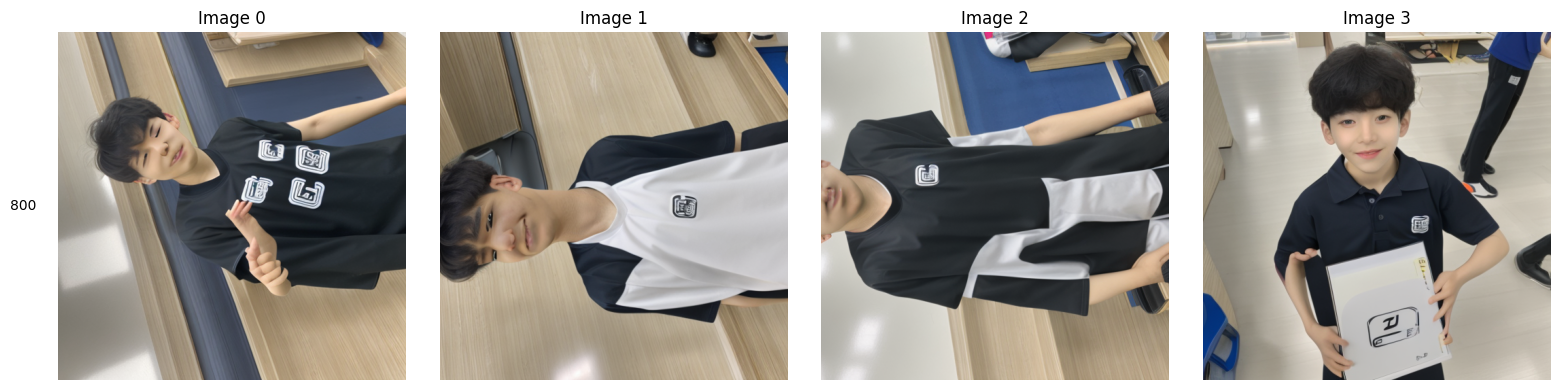

In [ ]:
# 가장 마지막에 존재하는 모델 가중치(weights)로 생성된 이미지에 대하여 시각화(visualization) 수행
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 가중치들이 저장되는 출력 폴더 경로
weights_folder = OUTPUT_DIR
# 자신이 학습했던 모델 가중치 파일들을 하나씩 확인
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

# 학습된 모델(가중치 파일)의 개수
row = len(folders)
# 가중치별로 생성된 샘플(sample)의 개수
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
# 저장할 이미지의 크기(scale)에 맞게 이미지 생성
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col * scale, row * scale), gridspec_kw={'hspace': 0, 'wspace': 0})

# 하나씩 가중치 파일이 들어있는 폴더를 확인하며
for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    # 현재의 모델로 생성한 이미지 파일 리스트
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            # 현재의 이미지에 대하여 제목(title) 기입
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')

plt.tight_layout()
plt.savefig('grid.png', dpi=72)

#### <b>참고 결과 (텍스트 인코더를 Fine-Tuning하지 않은 경우)</b>


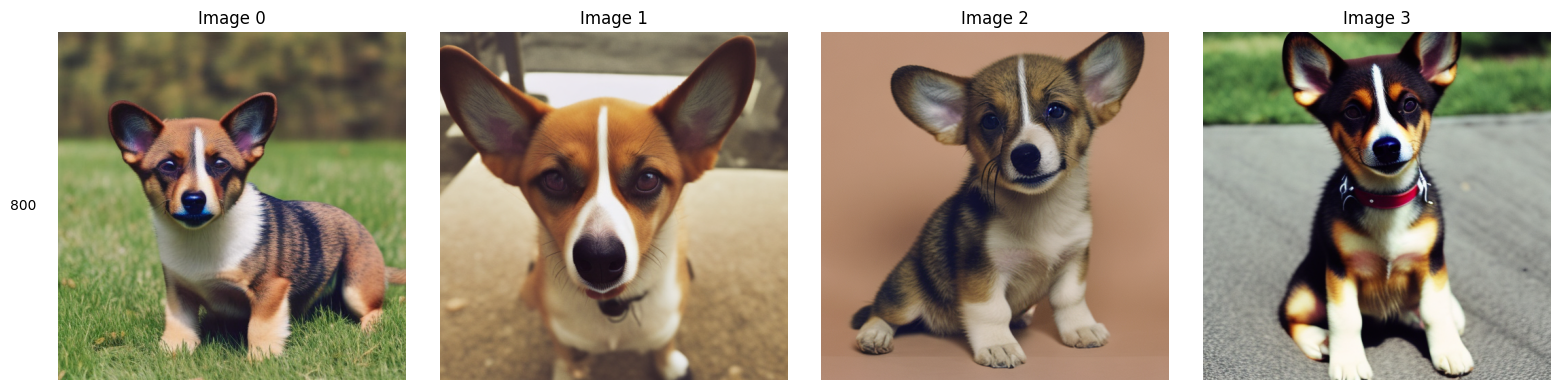

#### <b>.ckpt 파일 얻기</b>

* Convert weights to ckpt to use in web UIs like <b>AUTOMATIC1111</b>.

In [ ]:
# Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""

# Whether to convert to fp16, takes half the space (2GB).
fp16 = True
if fp16:
    half_arg = "--half"

In [ ]:
# Diffuers로 학습된 모델 내용을 일반적인 형태의 원본(original) Stable Diffusion 모델로 저장한다.
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/drive/MyDrive/stable_diffusion_weights/zwx/800/model.ckpt


#### <b>사전 학습된(Pre-trained) 모델을 이용한 추론(Inference)</b>

* 방금 학습한 모델을 포함하여 자기가 원하는 모델을 불러와 이미지를 생성할 수 있다.
* <b>Google Drive에 저장된 학습된 모델</b>의 전체 경로(full path)를 설정하여 아래 코드를 실행할 수 있다.
* If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive.

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR

# 사전 학습된 모델 불러오기
pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


#### <b>Reproducibility</b>

* Can set random seed here for reproducibility.

In [ ]:
g_cuda = torch.Generator(device='cuda')
seed = 9876 # 이미지 결과 reproducing을 위해 설정할 변수 값
g_cuda.manual_seed(seed)

#### <b>Run for Generating Images</b>

* Run for generating images.

  0%|          | 0/24 [00:00<?, ?it/s]

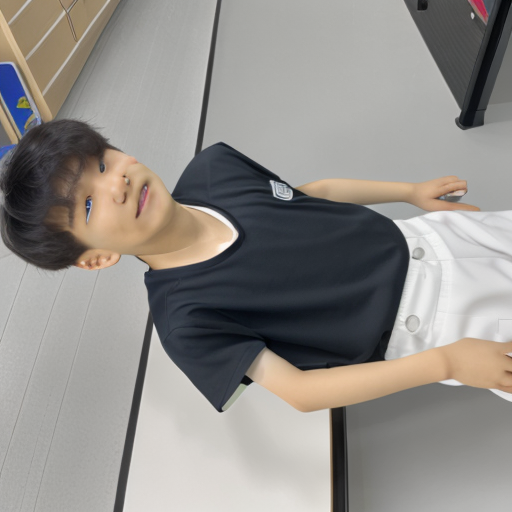

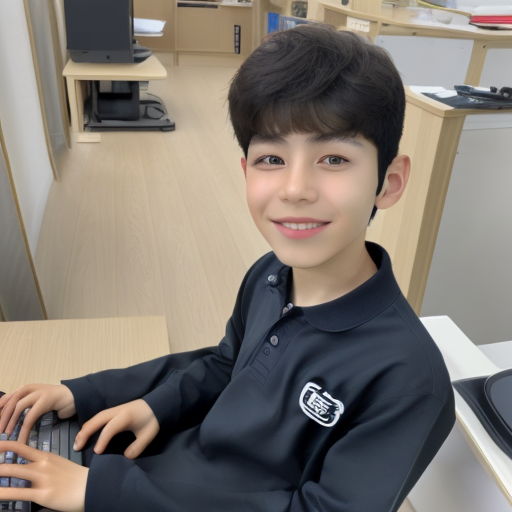

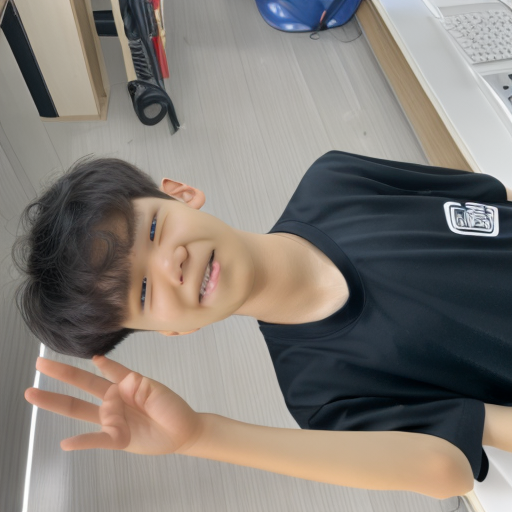

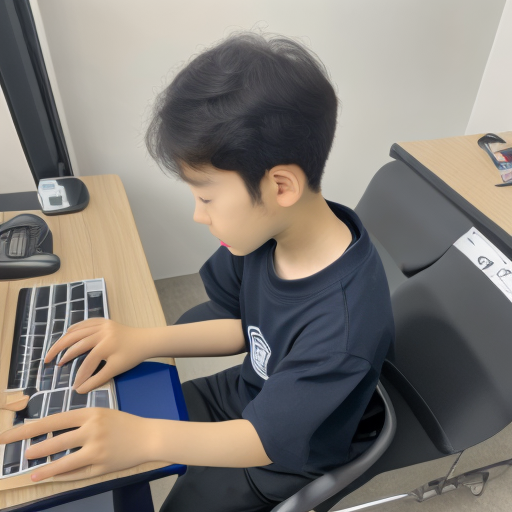

In [ ]:
prompt = "photo of zwx korean boy with computer"
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 24
height = 512
width = 512

# 모델에 대하여 추론(inference) 모드를 설정한다.
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

#### <b>(Optional) Gradio UI를 이용해 손쉽게 이미지 생성해보기</b>

* Web UI와 같은 환경에서 이미지를 생성하기 위해 다음과 같이 한다.

<pre>
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of zwx dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=24)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)
</pre>

#### <b>(Optional) Diffuser 가중치 제거하기</b>

* 앞선 코드에서 Fine-tuning을 위해 Diffuer Mdoel을 사용했다.
  * 실제로 사용할 때는 <b>최종적으로 변환된 .ckpt 파일만 이용</b>하여 추론(inference)할 수 있다.
  * 따라서, 원한다면 Google Drive 공간의 확보를 위하여 Diffuser 가중치는 제거할 수 있다.
* Delete diffuser and old weights and only keep the ckpt to free up drive space.
* Caution, <b>Only</b> execute if you are sure your want to delete the diffuser format weights and only use the ckpt.

<pre>
import shutil
from glob import glob
import os

# Diffuser 가중치(weight) 경로만 확인하여 제거
for f in glob(OUTPUT_DIR + os.sep + "*"):
    if f != WEIGHTS_DIR:
        shutil.rmtree(f)
        print("Deleted", f)
for f in glob(WEIGHTS_DIR+"/*"):
    if not f.endswith(".ckpt") or not f.endswith(".json"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)
</pre>

#### <b>Free Runtime Memory</b>

* 시연을 완료한 뒤에는 런타임 메모리를 초기화한다.

In [ ]:
exit()